# Tutorial 5: A Bayesian Inverse Problem - Inferring Ice Melt from Tide Gauges

In our previous tutorials, we have focused on the **forward problem**: predicting the Earth's response to a *known* change in ice mass. In this final tutorial, we will tackle the more realistic and challenging **inverse problem**: inferring an *unknown* ice mass change from a set of sparse and noisy observations.

We will use the full power of the `pyslfp` and `pygeoinf` libraries to solve this problem within a **Bayesian framework**. This is the state-of-the-art approach for geophysical inversion. Instead of finding a single "best-fit" solution, the Bayesian method provides a full **posterior probability distribution**. From this, we can extract the **posterior expectation**, which represents our most likely estimate of the ice melt pattern.

Our goal:
> Given sea-level measurements from the **Global Sea Level Observing System (GLOSS)** tide gauge network, what can we infer about the global pattern of ice thickness change that produced them?

## Setup

We begin by importing the necessary components from `pyslfp`, `pygeoinf`, and other standard libraries. We will also initialize our `FingerPrint` model, which provides the underlying physics.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pyslfp as sl
import pygeoinf as inf
import cartopy.crs as ccrs

# Initialize the core fingerprint model
fp = sl.FingerPrint(
    lmax=256,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp.set_state_from_ice_ng()

## Step 1: Loading the Tide Gauge Data

We will use the real locations from the GLOSS tide gauge network. The `read_gloss_tide_gauge_data` function in our `utils` module handles loading this data for us.

To make the problem computationally tractable and to simulate a scenario with sparse data, we will randomly subsample 30 stations from the full network. You can easily change this number or set `use_all_stations = True` to see how the result changes with more data.

In [14]:
# Load the full list of GLOSS tide gauge stations
names, lats, lons = sl.read_gloss_tide_gauge_data()

# --- Configuration for data selection ---
use_all_stations = True
number_of_stations_to_sample = 30
# -----------------------------------------

if use_all_stations:
    tide_gauge_points = list(zip(lats, lons))
else:
    # Create a reproducible random sample of stations
    random.seed(123)
    indices = random.sample(range(len(names)), number_of_stations_to_sample)
    sampled_lats = [lats[i] for i in indices]
    sampled_lons = [lons[i] for i in indices]
    tide_gauge_points = list(zip(sampled_lats, sampled_lons))

print(f"Using {len(tide_gauge_points)} tide gauge stations for the inversion.")

Using 75 tide gauge stations for the inversion.


## Step 2: Defining the Model Space

The next step is to define the space of possible solutions. Our unknown is the global pattern of **ice thickness change**. We will model this as a smooth, continuous field on the surface of the sphere.

A `pygeoinf.symmetric_space.sphere.Sobolev` space is the perfect choice for this. It's a function space that contains spatially smooth fields. We will give it a smoothness `order=2` and a characteristic `scale` of 500 km.

In [15]:
# Define the model space for the unknown ice thickness change
order = 2.0
scale_km = 500.0
scale = scale_km * 1000 / fp.mean_sea_floor_radius_si # Convert scale to non-dimensional units

model_space = inf.symmetric_space.sphere.Sobolev(
    fp.lmax, order, scale, radius=fp.mean_sea_floor_radius
)

## Step 3: Defining the Forward Operator

Next, we must define the **forward operator**. This is the mathematical object that represents the complete chain of physical processes and measurements linking our model (ice thickness change) to our data (tide gauge readings).

Using the operator algebra of `pygeoinf`, we can build this complex chain by composing several simpler operators:

1.  **`ice_thickness_change_to_load_operator`**: Takes an ice thickness change field and converts it to a surface mass load.
2.  **`fp.as_sobolev_linear_operator`**: The main fingerprint operator. It takes the mass load and calculates the full physical response: `[sea-level, displacement, gravity, rotation]`.
3.  **`tide_gauge_operator`**: This takes the full response and evaluate the sea level change at the discrete locations of our tide gauges.

The final forward operator, `A`, is the composition of all three steps.

In [16]:
# 1. Operator: Ice Thickness Change -> Surface Mass Load
op1 = sl.operators.ice_thickness_change_to_load_operator(fp, model_space, ice_projection=True)

# 2. Operator: Load -> Full Physical Response
op2 = fp.as_sobolev_linear_operator(order, scale)

# 3. Operator: Full Response -> Sea Level Change Field
op3 = op2.codomain.subspace_projection(0)

# Define the operator from ice thickness change to the sea-level field
A_sl = op3 @ op2 @ op1

# 4. Operator: Sea Level Field -> Tide Gauge Measurements
op4 = sl.operators.tide_gauge_operator(op2.codomain, tide_gauge_points)

# Compose with A_sl to create the final forward operator A
A = op4 @ op2 @ op1
data_space = A.codomain

## Step 4: Setting up the LinearForwardProblem

Now we bundle the forward operator `A` with a model for our measurement errors. We'll assume the tide gauge measurements are corrupted by random, uncorrelated Gaussian noise with a standard deviation of 5 cm.

The `pygeoinf.LinearForwardProblem` class encapsulates this entire structure: **data = A(model) + error**.

In [17]:
# Define the data error statistics
tide_gauge_std_dev_m = 0.05
data_error_measure = inf.GaussianMeasure.from_standard_deviation(
    data_space, tide_gauge_std_dev_m
)

# Bundle everything into a forward problem object
forward_problem = inf.LinearForwardProblem(
    A, data_error_measure=data_error_measure
)

## Step 5: Creating a Synthetic Reality

To test our inversion, we need a "ground truth" to compare our results against. We will create a synthetic reality by first generating a plausible "true" ice melt scenario.

We do this by defining a **prior probability distribution** on the model space. This "prior" represents our beliefs about the ice thickness change *before* seeing any data. We'll use a smooth, zero-mean Gaussian measure.

We then draw one random sample from this prior to be our `model_true`. Finally, we generate the `data` that this true model would produce by applying the forward operator and adding random noise.

In [18]:
# Define the prior distribution for the ice thickness change.
# We'll use a smooth Gaussian field with a pointwise standard deviation of 10 meters.
model_prior_measure = model_space.point_value_scaled_sobolev_kernel_gaussian_measure(
    order=4.0, scale=scale, amplitude=10.0
)

# --- Generate the synthetic ground truth and noisy data ---
model_true, data = forward_problem.synthetic_model_and_data(model_prior_measure)

### Visualizing the "True" Sea-Level Field

Before we solve the inverse problem, let's visualize the continuous sea-level fingerprint that corresponds to our `model_true`. This is the underlying signal that our sparse network of tide gauges is sampling. Plotting this helps to understand the challenge of the inverse problem and provides a visual reference for the magnitude of the data errors.

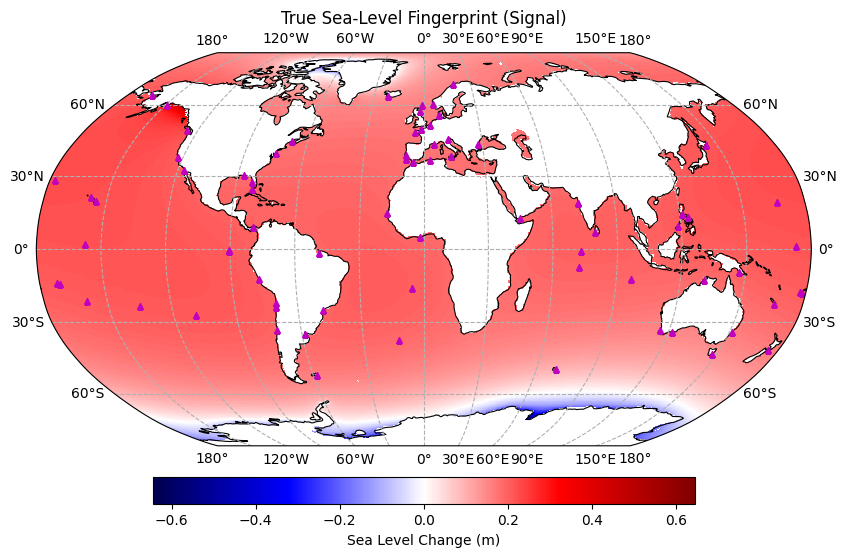

In [19]:
# Calculate the true sea-level field from the true ice model
sea_level_true = A_sl(model_true)

# Plot the true sea-level fingerprint
fig, ax, im = sl.plot(
    sea_level_true * fp.ocean_projection(),
    coasts=True,
    cmap="seismic",
    symmetric=True
)
ax.set_title("True Sea-Level Fingerprint (Signal)")

# Overlay the tide gauge locations to show what is being sampled
lats = [p[0] for p in tide_gauge_points]
lons = [p[1] for p in tide_gauge_points]
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())

fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

## Step 6: Solving the Bayesian Inverse Problem

Now we have all the ingredients to solve the inverse problem. We use the `pygeoinf.LinearBayesianInversion` class, providing it with our forward problem and our prior.

The `model_posterior_measure` method applies Bayes' theorem to combine the prior information with the information from the data. The result is the **posterior probability distribution**, which represents our updated, combined state of knowledge.

In [20]:
# Set up the Bayesian inversion method
bayesian_inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Solve for the posterior distribution
# We use a Cholesky solver for the underlying matrix inversion.
model_posterior_measure = bayesian_inversion.model_posterior_measure(
    data, inf.CholeskySolver()
)

## Step 7: Analyzing and Visualizing the Result

The primary result we are interested in is the **posterior expectation**. This is our best estimate of the true ice thickness change, given our prior beliefs and the information contained in the tide gauge data.

The full posterior distribution also contains the **posterior covariance**, which quantifies our uncertainty. For this tutorial, we will focus solely on the posterior expectation.

### Plotting the Inferred Ice Melt

First, we will create two separate plots to compare the "ground truth" ice melt with our inferred result:
1.  **The True Model:** The actual ice thickness change we were trying to recover.
2.  **The Posterior Expectation:** Our best estimate, which we hope resembles the true model.

To ensure a fair visual comparison, we will calculate a common color scale based on the maximum absolute value across both fields.

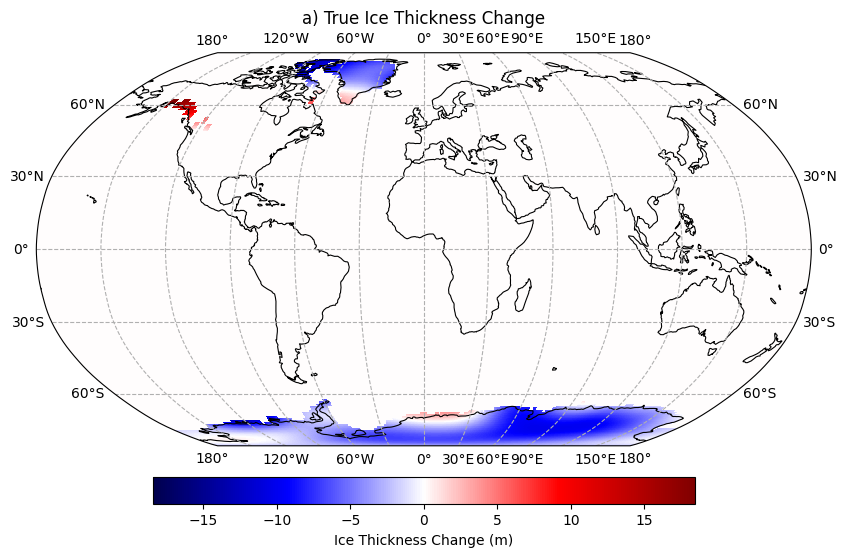

In [23]:
# --- Calculate a shared, symmetric color scale for the ice thickness plots ---
# We mask with the ice projection to avoid including NaNs in the calculation
ice_mask = fp.ice_projection(0)
max_abs_ice_change = np.nanmax(
    np.abs(
        np.concatenate([
            (model_true * ice_mask).data.flatten(),
            (model_posterior_expectation * ice_mask).data.flatten()
        ])
    )
)

# --- Plot 1: The "Ground Truth" Model ---
fig, ax, im = sl.plot(
    model_true * ice_mask,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_ice_change,
    vmax=max_abs_ice_change
)
ax.set_title("a) True Ice Thickness Change")
fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Ice Thickness Change (m)")
plt.show()

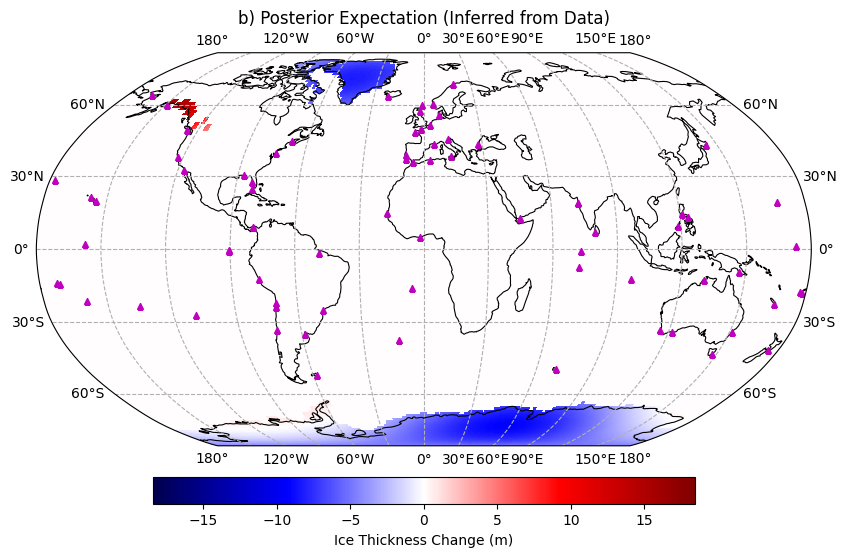

In [24]:
# --- Plot 2: The Posterior Expectation (Our Best Estimate) ---
fig, ax, im = sl.plot(
    model_posterior_expectation * fp.ice_projection(0),
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_ice_change,
    vmax=max_abs_ice_change
)
ax.set_title("b) Posterior Expectation (Inferred from Data)")

# Mark the tide gauge locations
lats = [p[0] for p in tide_gauge_points]
lons = [p[1] for p in tide_gauge_points]
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())

fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Ice Thickness Change (m)")
plt.show()

### Plotting the Predicted Sea Level

As a final check, we can use our inferred ice melt pattern (`model_posterior_expectation`) to predict the global sea-level fingerprint. By comparing this predicted fingerprint to the "true" fingerprint, we can visually assess how well our inversion has captured the large-scale signal.

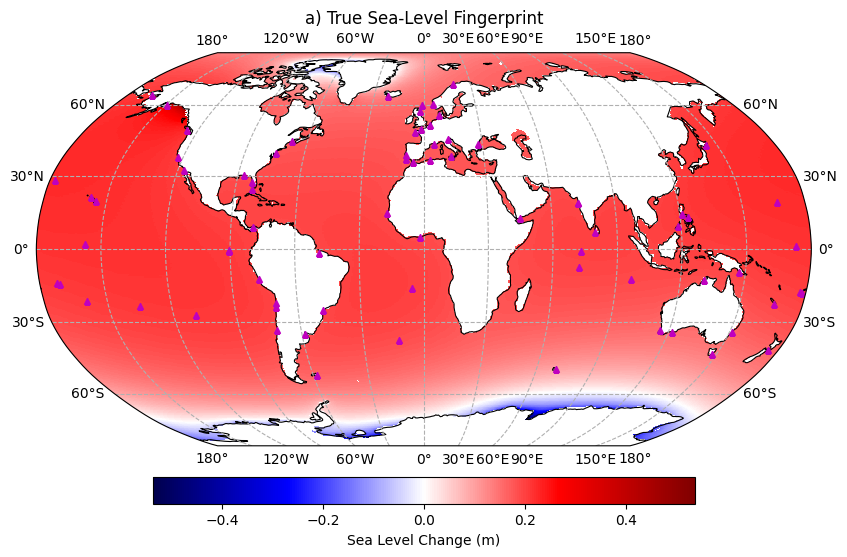

In [25]:

# Calculate the predicted sea-level field from the posterior expectation model
sea_level_posterior = A_sl(model_posterior_expectation)

# --- Calculate a shared, symmetric color scale for the sea-level plots ---
ocean_mask = fp.ocean_projection()
max_abs_sl_change = np.nanmax(
    np.abs(
        np.concatenate([
            (sea_level_true * ocean_mask).data.flatten(),
            (sea_level_posterior * ocean_mask).data.flatten()
        ])
    )
)


# --- Plot 3: The "True" Sea-Level Field ---
fig, ax, im = sl.plot(
    sea_level_true * ocean_mask,    
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax.set_title("a) True Sea-Level Fingerprint")
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

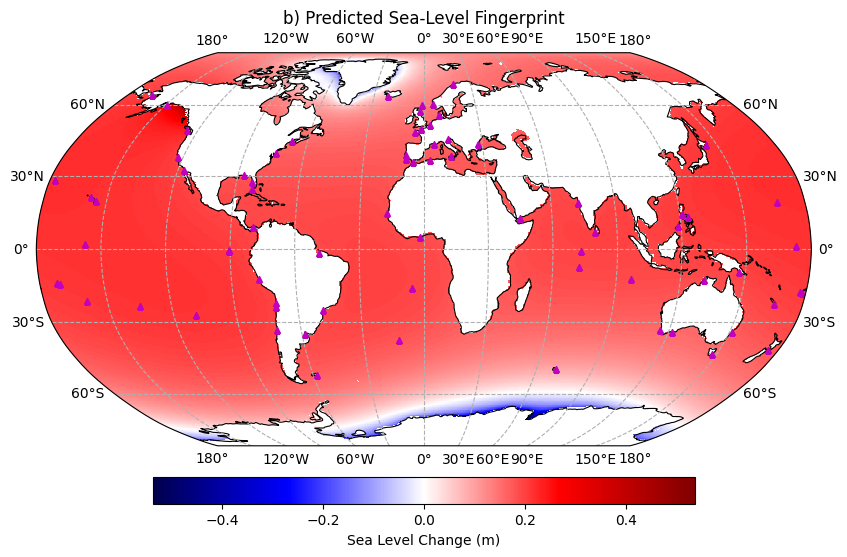

In [26]:
# --- Plot 4: The Sea-Level Field Predicted by the Inversion ---
fig, ax, im = sl.plot(
    sea_level_posterior * fp.ocean_projection(),
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax.set_title("b) Predicted Sea-Level Fingerprint")
ax.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

## Conclusion

In this tutorial, we have successfully performed a full Bayesian inversion to infer a global ice melt pattern from sparse, noisy data from the GLOSS tide gauge network.

The results show that:
* The **posterior expectation** for ice melt successfully recovers the large-scale features of the **true model**, even though it was derived from only a small subset of global tide gauges.
* The **predicted sea-level fingerprint** from our inversion result is a very good match for the true fingerprint, demonstrating that our solution is consistent with the physics of the problem.

This demonstrates the power of the Bayesian approach. It doesn't just give us an answer; it tells us how confident we should be in that answer, and where we would need to collect more data to improve our knowledge.